In [1]:
import pandas as pd
import numpy as np
import warnings

import string
from collections import Counter
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")

# read in dataset 
df = pd.read_csv("final_dataset.csv")
# extact publisher name
df['news_site'] = df['publisher'].apply(lambda x: eval(x)['title'] if isinstance(x, str) else None)

# convert date to datetime format
df['date'] = pd.to_datetime(df['published date'])
df_clean = df[['news_site', 'title', 'date']]

# helper function to clean headline data
def remove_after_last_hyphen(s):
    last_hyphen_index = s.rfind(' - ')
    if last_hyphen_index != -1:
        return s[:last_hyphen_index].strip()
    return s

# transforming headlines into lists of words
df_clean['processed_title'] = df_clean['title'].str.lower()
df_clean['processed_title'] = df_clean['processed_title'].apply(remove_after_last_hyphen)
df_clean['processed_title'] = df_clean['processed_title'].str.translate(str.maketrans('', '', string.punctuation))
df_clean['processed_title'] = df_clean['processed_title'].str.split()

df_clean.head(10)

,news_site,title,date,processed_title
0,Prism,Pro-Palestine student organizers face crackdow...,2024-03-05 08:00:00,"[propalestine, student, organizers, face, crac..."
1,The Oklahoma Daily,"150 students take part in pro-Palestine, pro-I...",2024-03-08 23:20:24,"[150, students, take, part, in, propalestine, ..."
2,Tufts Daily,Students protest Kumar’s condemnation of TCU S...,2024-03-06 08:00:00,"[students, protest, kumar’s, condemnation, of,..."
3,The Amherst Student,Amherst for Palestine Demands Divestment Outsi...,2024-03-06 08:00:00,"[amherst, for, palestine, demands, divestment,..."
4,Inside Higher Ed,Columbia's protest policy less stringent than ...,2024-03-07 08:00:00,"[columbias, protest, policy, less, stringent, ..."
5,The Vanderbilt Hustler,Vanderbilt students protest for prison reform ...,2024-03-04 08:00:00,"[vanderbilt, students, protest, for, prison, r..."
6,ABC 10 News San Diego KGTV,UCSD students organize large protest in suppor...,2024-03-06 08:00:00,"[ucsd, students, organize, large, protest, in,..."
7,Harvard Crimson,Student Protesters Accuse Harvard Administrato...,2024-03-04 08:00:00,"[student, protesters, accuse, harvard, adminis..."
8,WSKG.org,Ithaca Common Council calls for ceasefire in I...,2024-03-07 08:00:00,"[ithaca, common, council, calls, for, ceasefir..."
9,Tufts Daily,Students allege police aggression at Nov. 17 p...,2024-03-07 08:00:00,"[students, allege, police, aggression, at, nov..."


# TFIDF and Wordcloud clustering
Removed words that are less informative of each cluster

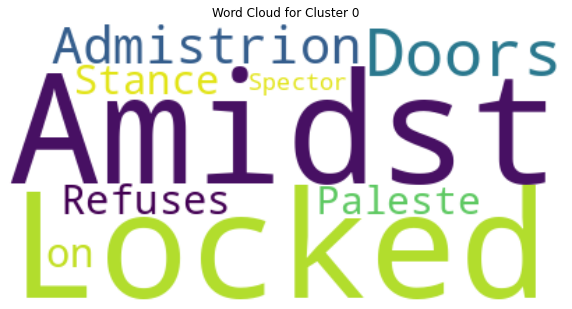

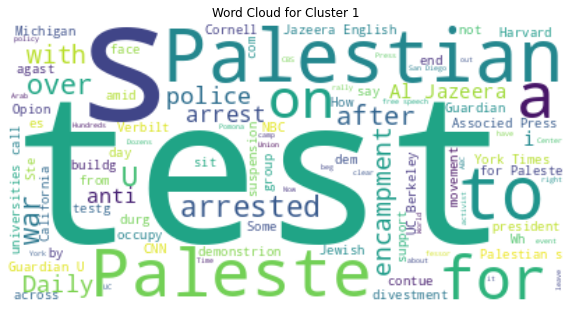

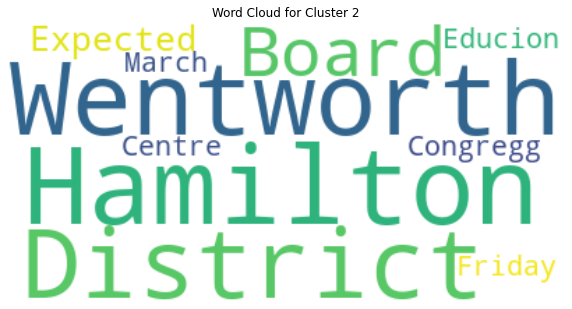

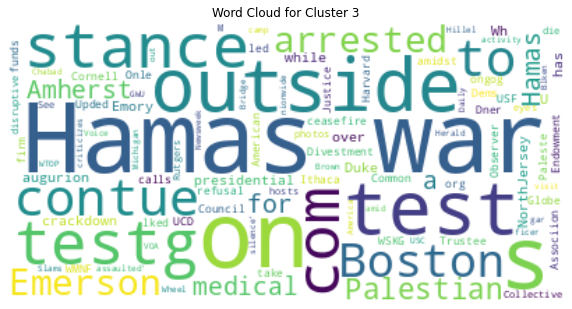

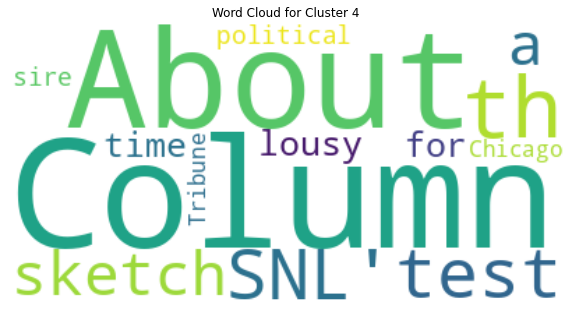

In [32]:
vectorizer = TfidfVectorizer(stop_words='english')
headline_vectors = vectorizer.fit_transform(df_clean['title'])

scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(headline_vectors)

num_clusters = 5

km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(X_scaled)
df_clean['cluster'] = km.labels_

keywords_to_remove = {'student', 'students', 'university', 'college', 'school', 'education', 'campus', 
                      'class', 'course', 'degree', 'faculty', 'protest', 'protesters', 'protester', 
                      'new', 'news', 'protests', 'propalestinian', 'gaza', 'columbia', 'palestine', 
                      'propalestine', 'palestinian', 'israel', 'israeli', 'pro', 'the', 'at',
                     'in', 'of', 'are', 'and'}

for cluster in range(num_clusters):
    cluster_data = df_clean[df_clean['cluster'] == cluster]['title']
    text = ' '.join(cluster_data)
    
    for word in keywords_to_remove:
        text = text.replace(word, '')

    wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue', stopwords=keywords_to_remove)
    wordcloud.generate_from_text(text)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

# Wordcloud without Clusters

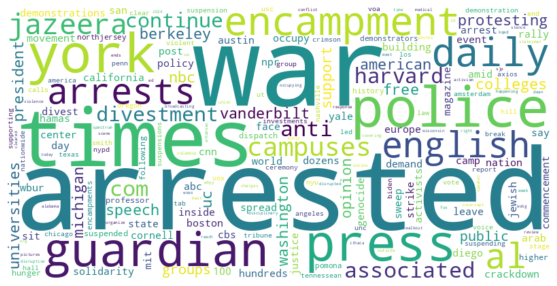

In [33]:
titles = df_clean['title'].astype(str)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(titles)
tfidf_scores = dict(zip(vectorizer.get_feature_names(), tfidf_matrix.sum(axis=0).tolist()[0]))

keywords_to_remove = {'student', 'students', 'university', 'college', 'school', 'education', 'campus', 
                      'class', 'course', 'degree', 'faculty', 'protest', 'protesters', 'protester', 
                      'new', 'news', 'protests', 'propalestinian', 'gaza', 'columbia', 'palestine', 
                      'propalestine', 'palestinian', 'israel', 'israeli', 'pro', 'the', 'at',
                     'in', 'of', 'are', 'and'}

filtered_tfidf_scores = {word: score for word, score in tfidf_scores.items() if word not in keywords_to_remove}

wordcloud_filtered = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_tfidf_scores)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_filtered, interpolation='bilinear')
plt.axis('off')
plt.show()

## Using TF-IDF

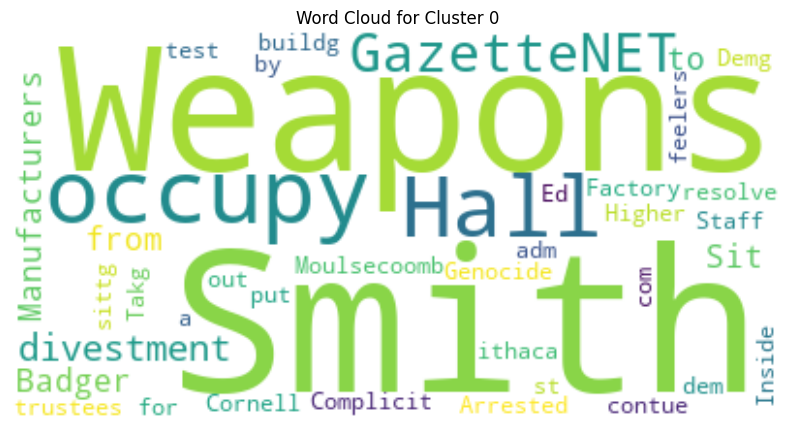

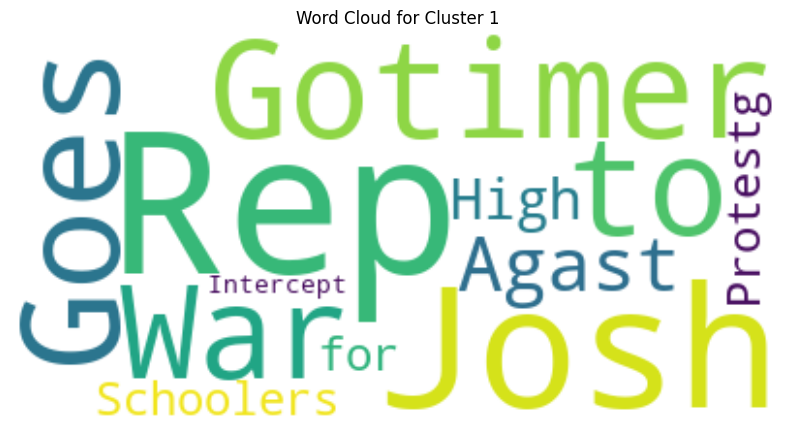

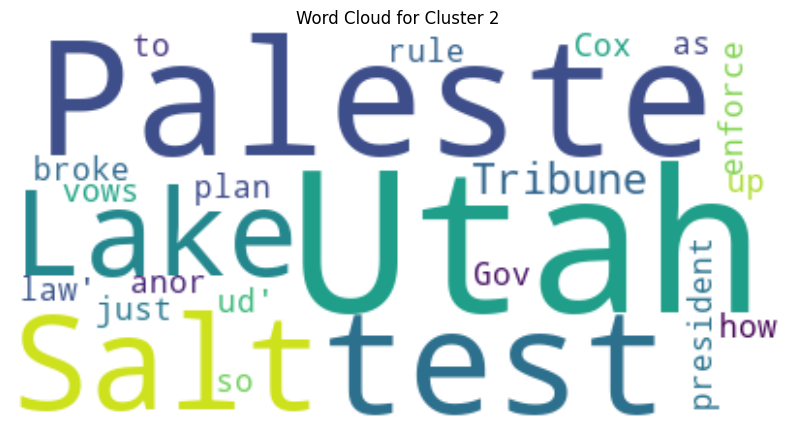

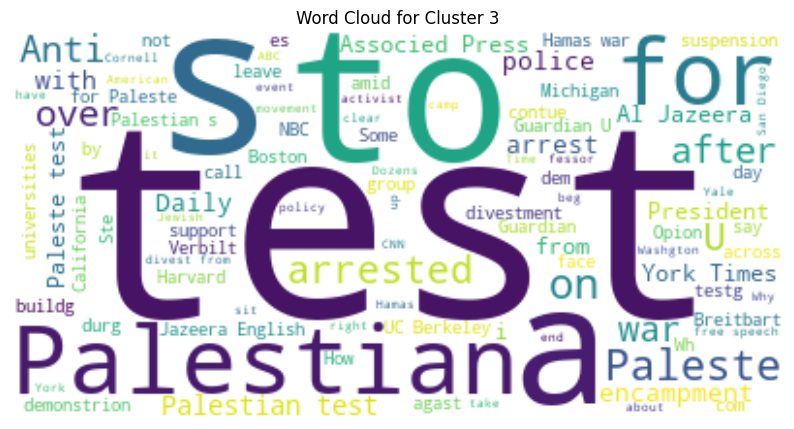

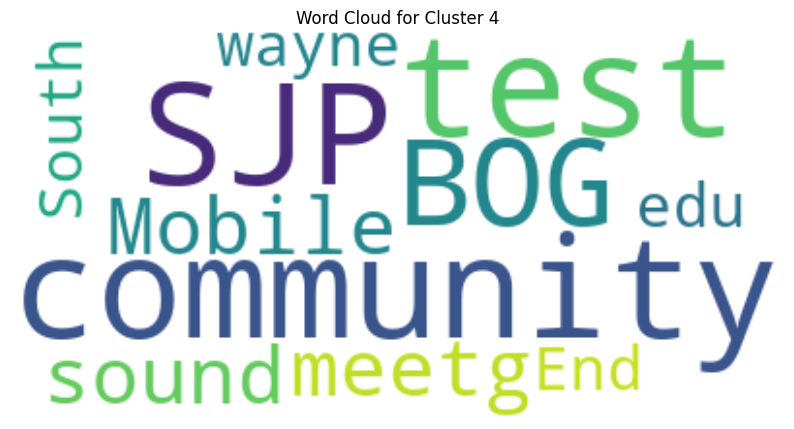

In [35]:
vectorizer = TfidfVectorizer(stop_words='english')
headline_vectors = vectorizer.fit_transform(df_clean['title'])

scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(headline_vectors)

num_clusters = 5

km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(X_scaled)
df_clean['cluster'] = km.labels_

keywords_to_remove = {'student', 'students', 'university', 'college', 'school', 'education', 'campus', 
                      'class', 'course', 'degree', 'faculty', 'protest', 'protesters', 'protester', 
                      'new', 'news', 'protests', 'propalestinian', 'gaza', 'columbia', 'palestine', 
                      'propalestine', 'palestinian', 'israel', 'israeli', 'pro', 'the', 'at',
                     'in', 'of', 'are', 'and'}

for cluster in range(num_clusters):
    cluster_data = df_clean[df_clean['cluster'] == cluster]['title']
    text = ' '.join(cluster_data)
    
    for word in keywords_to_remove:
        text = text.replace(word, '')

    wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue', stopwords=keywords_to_remove)
    wordcloud.generate_from_text(text)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

# Relationship Between Political Learning Score and Sentiment 

In [3]:
from sklearn.preprocessing import StandardScaler

# reading in media bias score data
biases = pd.read_excel('political_leaning.xlsx').loc[:,['news_site', 'score', 'allsides']].dropna()

scaler = StandardScaler()
# scale allSides score
biases['allsides_stand'] = scaler.fit_transform(biases[['allsides']])

biases.head()

,news_site,score,allsides,allsides_stand
0,CNN,-0.5,-1.3,-0.359046
1,The Associated Press,-0.5,-1.3,-0.359046
4,NBC News,-0.5,-1.8,-0.528750
5,NBC Boston,-0.5,-1.8,-0.528750
6,NBC New York,-0.5,-1.8,-0.528750


In [4]:
# adding bias score to original df
df_bias = df_clean.merge(biases, on='news_site', how='right')
df_bias.head()

,news_site,title,date,processed_title,score,allsides,allsides_stand
0,CNN,Students at more universities announce solidar...,2024-04-19 07:00:00,"[students, at, more, universities, announce, s...",-0.5,-1.3,-0.359046
1,CNN,"April 27, 2024 - Campus protest updates - CNN",2024-04-27 07:00:00,"[april, 27, 2024, campus, protest, updates]",-0.5,-1.3,-0.359046
2,CNN,Where pro-Palestinian university protests are ...,2024-05-03 07:00:00,"[where, propalestinian, university, protests, ...",-0.5,-1.3,-0.359046
3,CNN,"At the student protest at UPenn, passions are ...",2024-05-02 07:00:00,"[at, the, student, protest, at, upenn, passion...",-0.5,-1.3,-0.359046
4,CNN,In pictures: A lookback at student protest mov...,2024-04-30 07:00:00,"[in, pictures, a, lookback, at, student, prote...",-0.5,-1.3,-0.359046


### Visualizing Media Bias

Text(0.5, 1.0, 'Distribution of Media Bias Score')

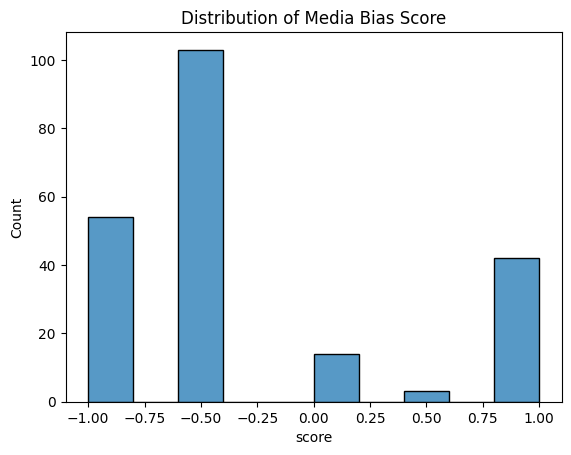

In [153]:
sns.histplot(df_bias['score'])
plt.title('Distribution of Media Bias Score')

Text(0.5, 1.0, 'Distribution of AllSides Standardized Bias Score')

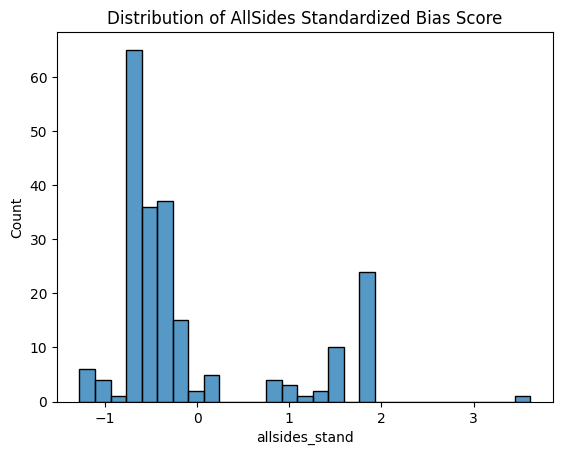

In [167]:
sns.histplot(df_bias['allsides_stand'])
plt.title('Distribution of AllSides Standardized Bias Score')

In [175]:
def get_score(score): 
    if score < 0: 
        return -1
    elif score > 0: 
        return 1
    else: 
        return 0
df_bias['simple_score'] = df_bias['score'].apply(get_score)

Text(0.5, 1.0, 'Distribution of News Sites and Media Bias Scores')

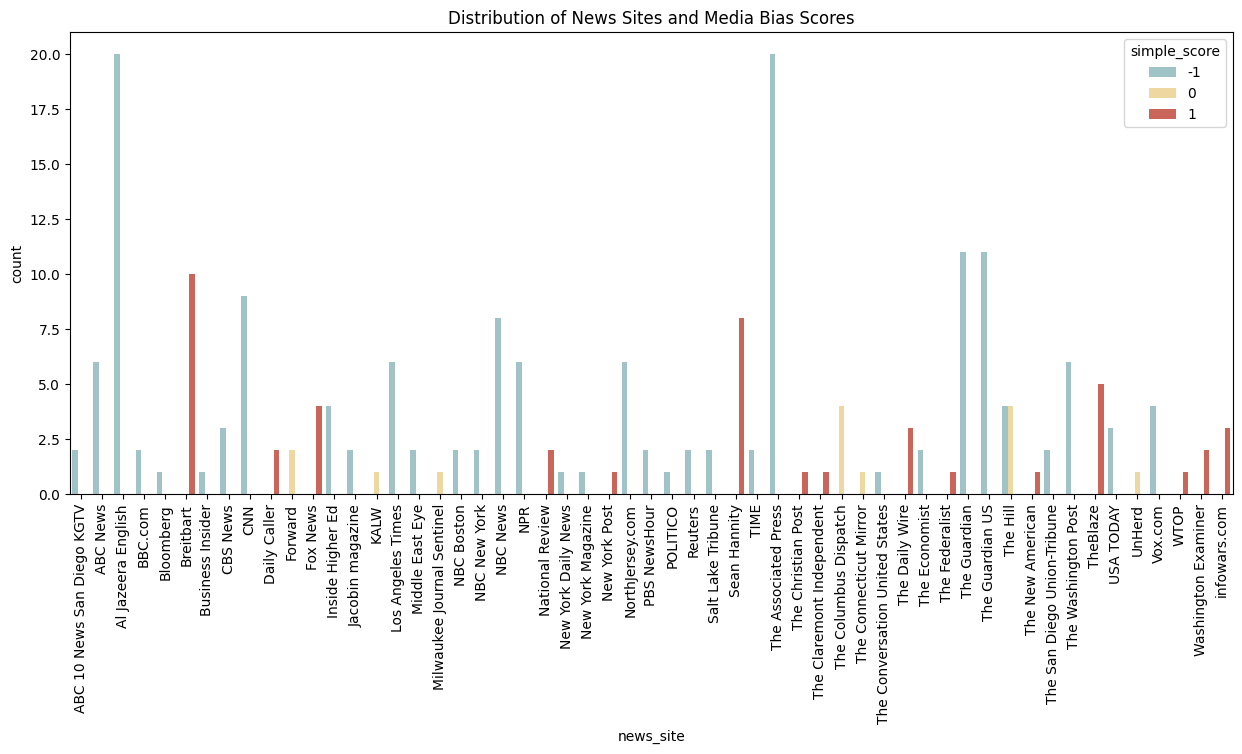

In [178]:
plt.figure(figsize=(15, 6)) 
sns.countplot(df_bias.sort_values('news_site'), x = 'news_site', hue='simple_score', palette = ['#9AC8CD', '#FCDC94', '#DD5746'])
plt.xticks(rotation=90)
plt.title('Distribution of News Sites and Media Bias Scores')

## Sentiment Analysis

In [6]:
from transformers import pipeline
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# adding sentiment score 

# hugging face
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

df_bias['huggingFace'] = df_bias['processed_title'].str.join(' ').apply(sentiment_analysis)
df_bias['huggingFace'] = df_bias['huggingFace'].apply(lambda x: -1 if x[0]['label'] == 'NEGATIVE' else 1)

# textBlob
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df_bias['textBlob'] = df_bias['processed_title'].str.join(' ').apply(get_sentiment)

# VADER
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    return sia.polarity_scores(text)['compound']

df_bias['vader'] = df_bias['processed_title'].str.join(' ').apply(get_vader_sentiment)

df_bias.head()

2024-06-13 02:32:01.336816: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 02:32:01.394005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'textblob'

Text(0.5, 1.0, 'Text Blob Sentiment')

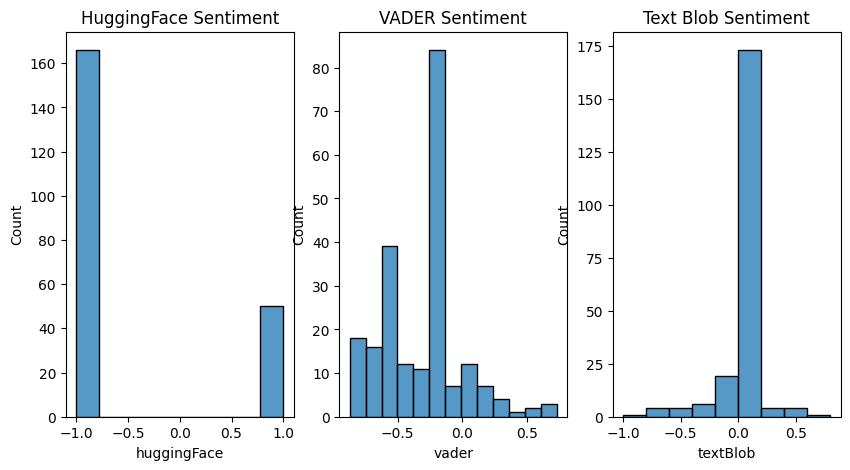

In [180]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.histplot(df_bias['huggingFace'], ax=axes[0])
axes[0].set_title('HuggingFace Sentiment')

sns.histplot(df_bias['vader'], ax=axes[1])
axes[1].set_title('VADER Sentiment')

sns.histplot(df_bias['textBlob'], ax=axes[2])
axes[2].set_title('Text Blob Sentiment')

### Looking at the distribution of the three sentiment score methods, we decided to proceed with VADER. Unlike the Hugging Face model, it has a continuous distribution which would be more helpful for analysis. It also has a greater variation in scores, compared to textBlob.

In [181]:
# create binary score for some plots
df_bias['binary_sentiment'] = df_bias['vader'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else -1))

Text(0.5, 1.0, 'Distribution of News Sites and Sentiment Scores')

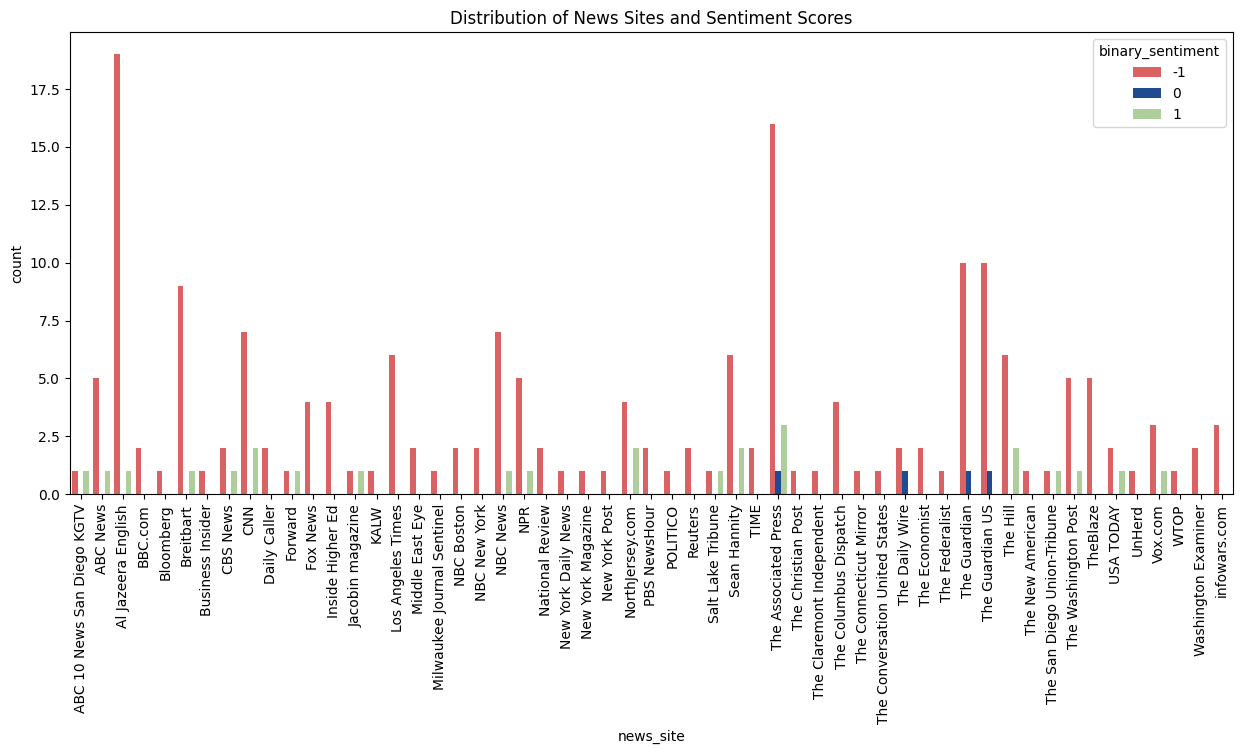

In [182]:
plt.figure(figsize=(15, 6)) 
sns.countplot(df_bias.sort_values('news_site'), x = 'news_site', hue='binary_sentiment', palette = ['#EE4E4E', '#0E46A3', '#ACD793'])
plt.xticks(rotation=90)
plt.title('Distribution of News Sites and Sentiment Scores')

Text(0.5, 0, 'Political Leaning Score')

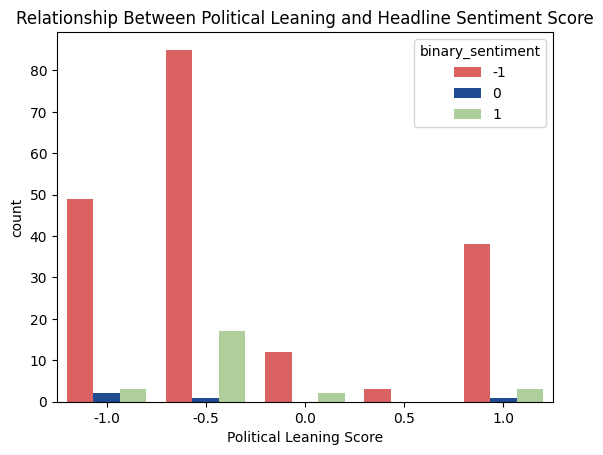

In [189]:
sns.countplot(df_bias, x = 'score', hue = 'binary_sentiment', palette = ['#EE4E4E', '#0E46A3','#ACD793'])
plt.title('Relationship Between Political Leaning and Headline Sentiment Score')
plt.xlabel('Political Leaning Score')


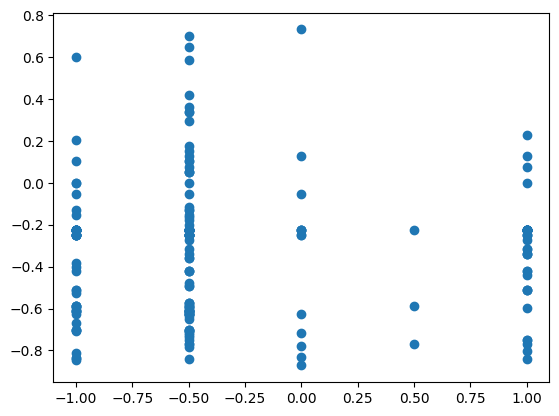

In [196]:
plt.scatter(x='score', y='vader', data=df_bias)

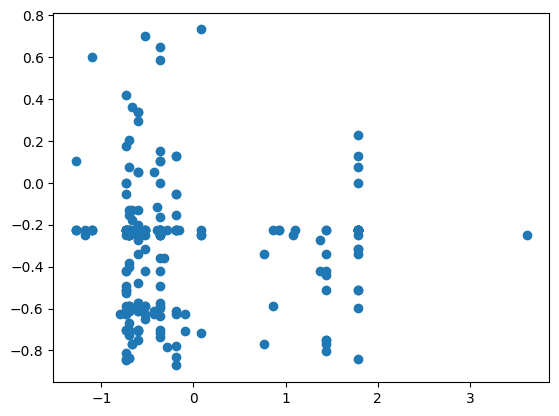

In [190]:
plt.scatter(x='allsides_stand', y='vader', data=df_bias)

## Linear Regression

In [191]:
import statsmodels.api as sm

Y = df_bias['vader'].values
X = df_bias['allsides_stand'].values

model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              1.969
Date:                Wed, 12 Jun 2024   Prob (F-statistic):                       0.162
Time:                        16:18:39   Log-Likelihood:                         -133.61
No. Observations:                 216   AIC:                                      269.2
Df Residuals:                     215   BIC:                                      272.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [195]:
# Trying again but with a squared term 
Y = df_bias['vader'].values
X = df_bias['score'].values

# Create the squared term
X_squared = X ** 2

# Fit the model
model = sm.OLS(Y, X_squared)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.382
Model:                            OLS   Adj. R-squared (uncentered):              0.379
Method:                 Least Squares   F-statistic:                              132.9
Date:                Wed, 12 Jun 2024   Prob (F-statistic):                    2.93e-24
Time:                        16:19:18   Log-Likelihood:                         -82.607
No. Observations:                 216   AIC:                                      167.2
Df Residuals:                     215   BIC:                                      170.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------